In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

import tqdm
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt

from math import sqrt

from arch import arch_model

In [17]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [14]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

#### Задание:  
1) Выберите ряд из первого задания и постройте его модель ARIMA/GARCH.

2) Дополнительное задание: попробуйте спрогнозировать график классическим ML.

###  1. Ряд с количеством регистраций автомобилий в США

In [15]:
df = pd.read_csv("monthly-us-auto-registration-tho.csv", sep= ';')
df.columns = ['Month','Count']

series = df['Count']

## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: 3020.01742 | order: (4, 2, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -4.324791
p-value                          0.000402
#Lags Used                      15.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


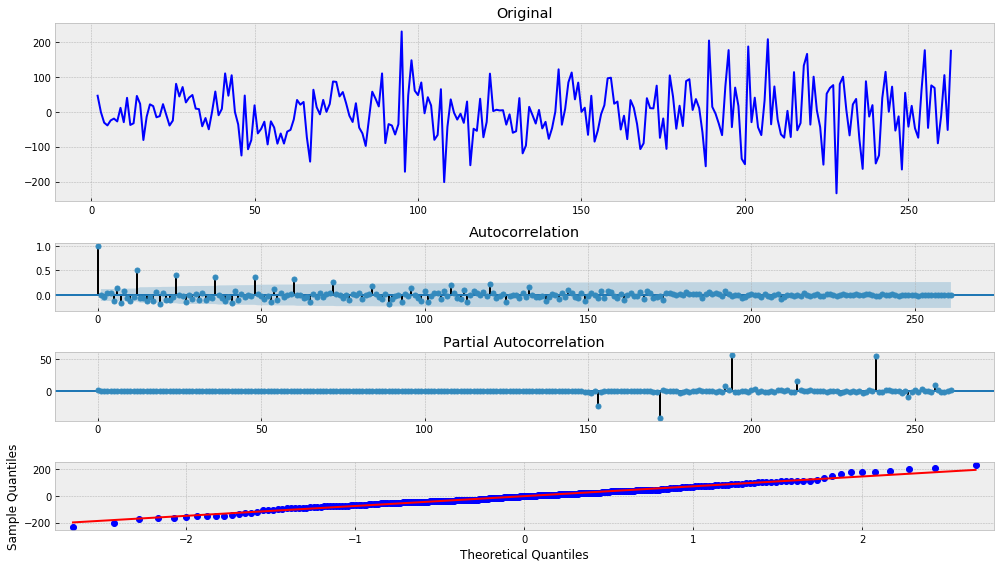

In [32]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid)

в остатках прослеживается сезонность 12 месяцев, которая не убирается двойным дифференцированием на предыдущее значение
можно ли считать, что это ок?

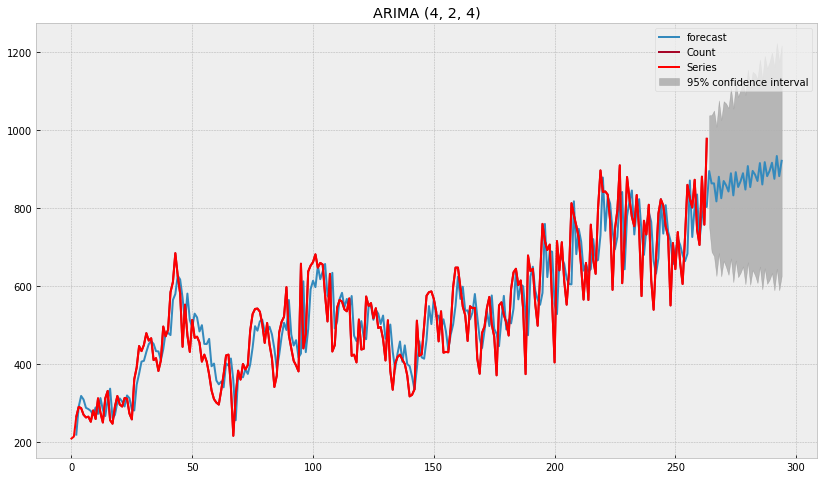

In [31]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(2, len(series)+30, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.title(f'ARIMA {best_order}')
    plt.legend()
    plt.show()

прогноз вполне адекватный

## GARCH

In [36]:
#установка
#!pip install arch --install-option="--no-binary"

In [78]:
series_stat = boxcox(series, 0)
series_stat = series_stat[1:] - series_stat[:-1]
series_stat = series_stat[12:] - series_stat[:-12]

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


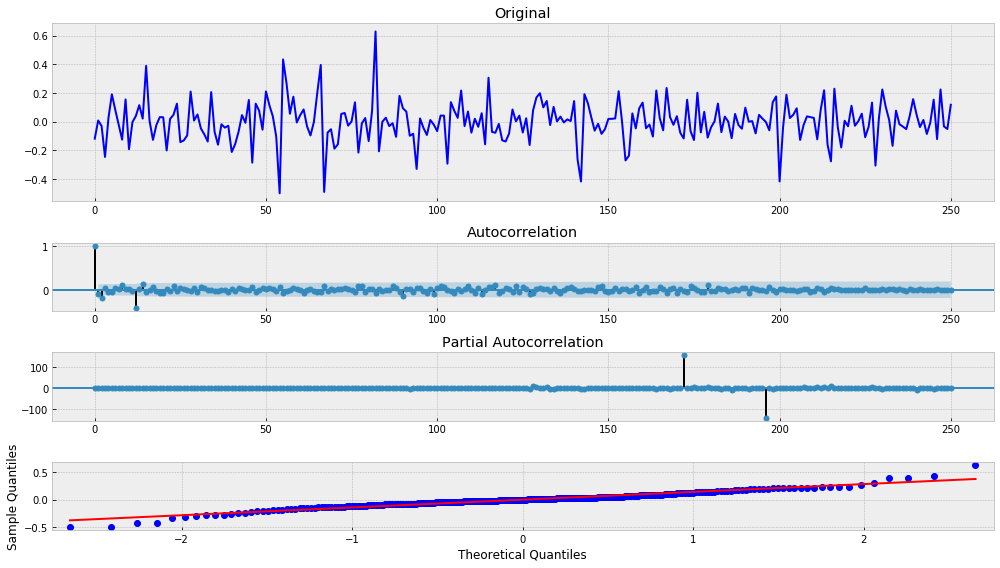

In [79]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 4
o_ = 2
q_ = 4

# Using student T distribution usually provides better fit
am = arch_model(series_stat, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')

tsplot(res.resid)

In [105]:
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                152.487
Distribution:      Standardized Student's t   AIC:                          -278.973
Method:                  Maximum Likelihood   BIC:                          -233.142
                                              No. Observations:                  251
Date:                      Mon, May 27 2019   Df Residuals:                      238
Time:                              16:21:41   Df Model:                           13
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                -1.075078e+01
p-value                        2.668822e-19
#Lags Used                     2.000000e+00
Number of Observations Used    2.670000e+02
Critical Value (1%)           -3.455081e+00
Critical Value (5%)           -2.872427e+00
Critical Value (10%)          -2.572571e+00
dtype: float64


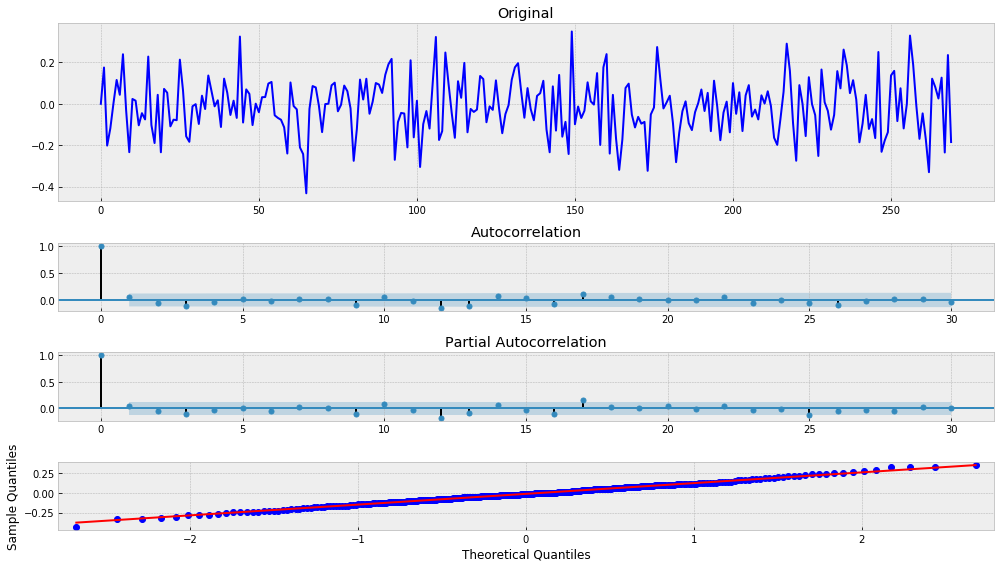

In [202]:
a0 = 0.0159
a1 = 0.2282 
b1 = 0.007175

n = 270
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(-0.00022123 + eps, lags=30)

остатки в норме по p-value и визуальной оценке

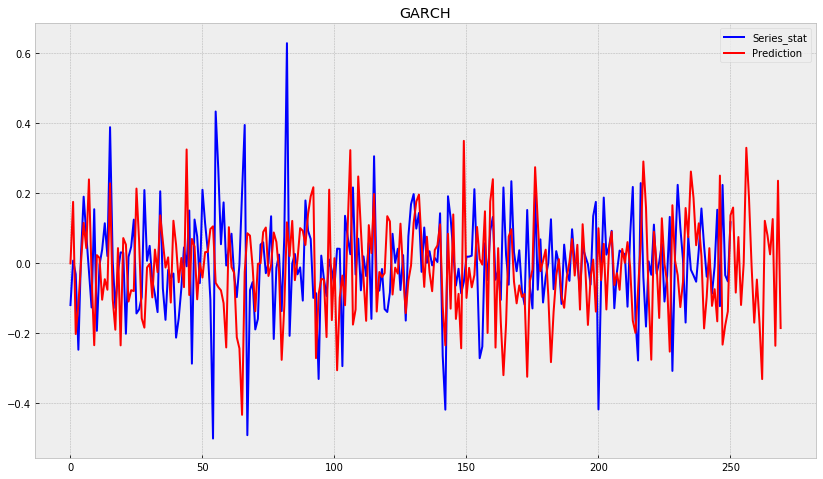

In [203]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(series_stat, color='blue', label='Series_stat')
    plt.plot(eps, color='red', label='Prediction')
    plt.title(f'GARCH')
    plt.legend()
    plt.show()  

 ### Альтернатива: добавляем фичи и делаем прогноз через линейную регрессию

In [206]:
def prepareData(data, lag_start=1, lag_end=4, test_size=0.30):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    #data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [207]:
df = pd.read_csv("monthly-us-auto-registration-tho.csv", sep= ';')
df.columns = ['Month','Count']

In [208]:
date = df['Month'].str.split("-",expand = True)

In [209]:
df['Month']= date[1]

In [210]:
сategorical_columns = ['Month']

In [211]:
for x in сategorical_columns:
    df = pd.concat([df, pd.get_dummies(df[x], prefix=x)], axis=1)
    df = df.drop(x, axis=1)

In [212]:
X_train, X_test, y_train, y_test = prepareData(df, lag_start=1, lag_end=5, test_size=0.3)

8209.60391156175

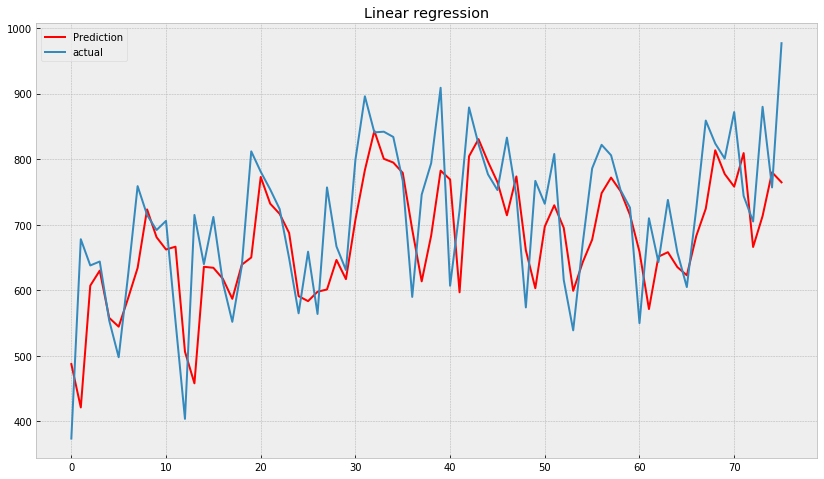

In [225]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="Prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

mean_squared_error(prediction, y_test)

In [223]:
import xgboost
from sklearn.metrics import mean_squared_error

20285.186846149496

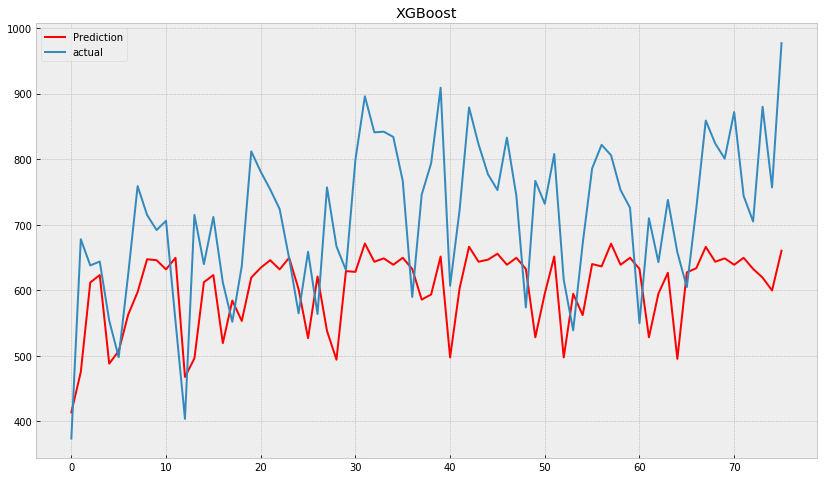

In [224]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)

prediction = xgb.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="Prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("XGBoost")
plt.grid(True);

mean_squared_error(prediction, y_test)

Линейная регрессия оказалась лучше XGBoost для прогнозирования